# Transforming intent
# ===================
# 




## Load libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [117]:
from sklearn.pipeline import make_pipeline, Pipeline

import numpy as np
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


time: 1.1 ms (started: 2023-01-20 16:40:00 -05:00)


In [4]:
import sys

In [5]:
sys.version

'3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) \n[Clang 11.1.0 ]'

In [6]:
pd.options.display.max_rows = 2000

In [7]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 475 µs (started: 2023-01-17 18:43:27 -05:00)


## Load data

In [9]:
!ls -l ./data

total 2120
-rw-r--r--  1 szalmaf  staff    2036 Jan 17 12:39 categories.json
-rw-r--r--  1 szalmaf  staff  239961 Jan 17 12:39 test.csv
-rw-r--r--  1 szalmaf  staff  839073 Jan 17 12:39 train.csv
time: 172 ms (started: 2023-01-17 18:46:05 -05:00)


In [70]:
drctry = r'./data/'
df_train = pd.read_csv(drctry + 'train.csv')
df_test = pd.read_csv(drctry + 'test.csv')

time: 31.2 ms (started: 2023-01-20 15:32:21 -05:00)


In [71]:
df_train

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival
...,...,...
9998,You provide support in what countries?,country_support
9999,What countries are you supporting?,country_support
10000,What countries are getting support?,country_support
10001,Are cards available in the EU?,country_support


time: 16.2 ms (started: 2023-01-20 15:32:28 -05:00)


In [72]:
df_test

,text,category
0,How do I locate my card?,card_arrival
1,"I still have not received my new card, I order...",card_arrival
2,I ordered a card but it has not arrived. Help ...,card_arrival
3,Is there a way to know when my card will arrive?,card_arrival
4,My card has not arrived yet.,card_arrival
...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support
3076,How many countries do you support?,country_support
3077,What countries do you do business in?,country_support
3078,What are the countries you operate in.,country_support


time: 14.7 ms (started: 2023-01-20 15:32:32 -05:00)


In [75]:
df_all = df_train.append(df_test, ignore_index=True)
# df_train['category'].unique()
df_all

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival
...,...,...
13078,"If i'm not in the UK, can I still get a card?",country_support
13079,How many countries do you support?,country_support
13080,What countries do you do business in?,country_support
13081,What are the countries you operate in.,country_support


time: 17.1 ms (started: 2023-01-20 15:35:43 -05:00)


### Basic stats of dataset

#### Intent distribution

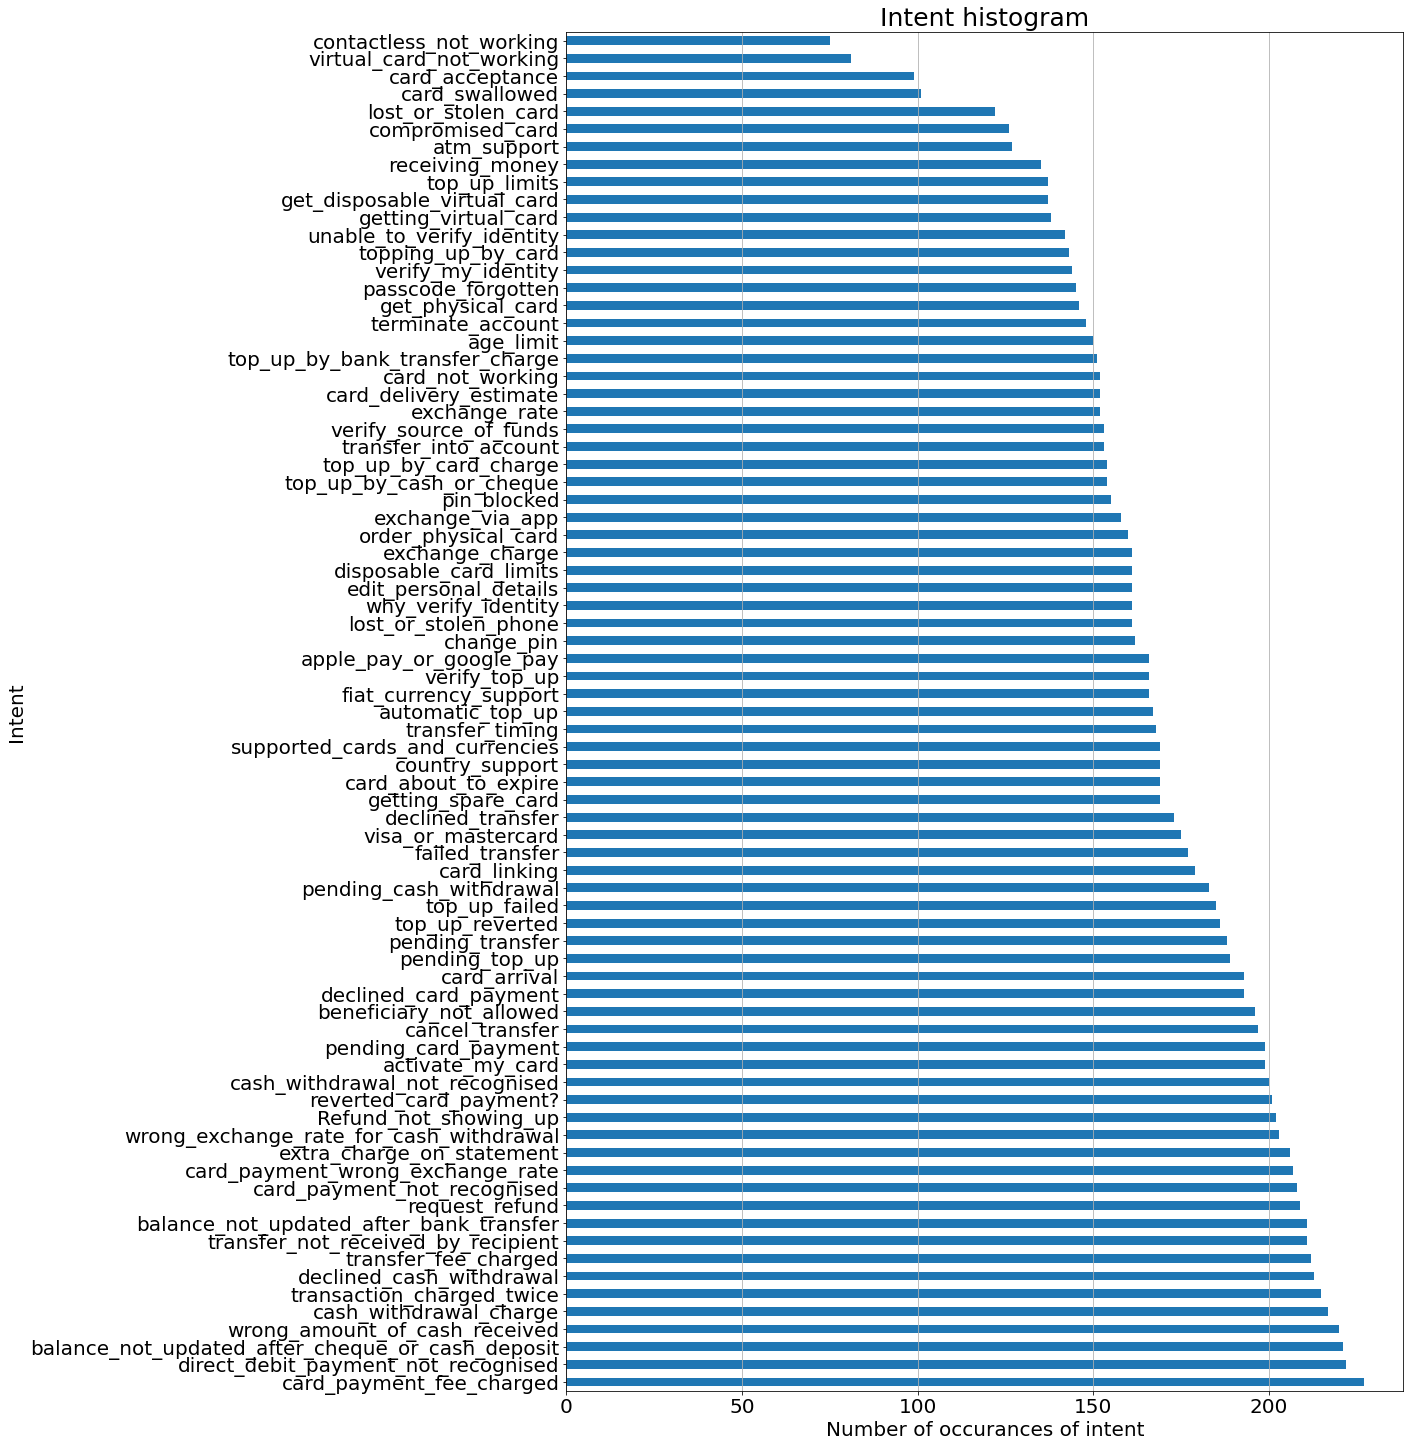

time: 486 ms (started: 2023-01-20 15:35:58 -05:00)


In [76]:
# Subintent distribution
ax = df_all['category'].value_counts(normalize=False).plot.barh(figsize=(15,25))
ax.set_title('Intent histogram', fontsize=25)
ax.set_xlabel('Number of occurances of intent', fontsize=20)
ax.set_ylabel('Intent', fontsize=20)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid(axis='x')

In [77]:
pd.DataFrame(pd.Series([item for item in df_all["category"]]).value_counts(normalize=False))

,0
card_payment_fee_charged,227
direct_debit_payment_not_recognised,222
balance_not_updated_after_cheque_or_cash_deposit,221
wrong_amount_of_cash_received,220
cash_withdrawal_charge,217
transaction_charged_twice,215
declined_cash_withdrawal,213
transfer_fee_charged,212
transfer_not_received_by_recipient,211
balance_not_updated_after_bank_transfer,211


time: 17.1 ms (started: 2023-01-20 15:36:11 -05:00)


## Word vectors

### Tf-idf (term frequncy inverse document frequency) word vectors

#### 10003 utterances, vocabulary of 2320 words

In [78]:
cntvectzr = CountVectorizer()
data_counts = cntvectzr.fit_transform(df_all['text'])
data_counts.shape

(13083, 2532)

time: 77.5 ms (started: 2023-01-20 15:36:19 -05:00)


In [79]:
data_tfidf = TfidfTransformer().fit_transform(data_counts)
data_tfidf.shape

(13083, 2532)

time: 18.3 ms (started: 2023-01-20 15:36:23 -05:00)


In [80]:
pd.DataFrame(data_tfidf.toarray().T, index=cntvectzr.get_feature_names())

/Users/szalmaf/.pyenv/versions/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3,4,5,6,7,8,9,...,13073,13074,13075,13076,13077,13078,13079,13080,13081,13082
00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youngest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
your,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
youre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yours,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 47.3 ms (started: 2023-01-20 15:36:29 -05:00)


## Modeling: Naive Bayes model

### Model pipeline

In [100]:
model_NB = make_pipeline(
                CountVectorizer(),
                TfidfTransformer(),
                ComplementNB())  #force_alpha=True))

time: 1.23 ms (started: 2023-01-20 16:30:52 -05:00)


### Learning curve

In [101]:
train_sizes = np.logspace(np.log(0.2), np.log(1.0), num=20, endpoint=True)  # np.linspace(0.1, 1.0, num=10, endpoint=True)

time: 723 µs (started: 2023-01-20 16:30:56 -05:00)


In [102]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

time: 508 µs (started: 2023-01-20 16:30:57 -05:00)


In [104]:
results = learning_curve(estimator = model_NB,
                         X = df_all['text'],
                         y = df_all['category'],
                         train_sizes = train_sizes,
                         cv = cv,
                         scoring ='f1_macro')
train_size, train_scores, test_scores = results[:3]

time: 6.12 s (started: 2023-01-20 16:31:15 -05:00)


In [105]:
train_size

array([  257,   312,   379,   461,   561,   682,   829,  1007,  1224,
        1488,  1808,  2198,  2671,  3247,  3946,  4796,  5829,  7085,
        8611, 10466])

time: 5.25 ms (started: 2023-01-20 16:31:27 -05:00)


In [106]:
train_scores, test_scores

(array([[0.98700729, 0.98911546, 0.97534603, 0.9870904 , 0.98579972],
        [0.99068462, 0.98911546, 0.98501841, 0.98782314, 0.99076878],
        [0.99311154, 0.9855896 , 0.98533144, 0.99106459, 0.9896151 ],
        [0.98876519, 0.9850012 , 0.97735727, 0.9774814 , 0.98642718],
        [0.98517622, 0.98595187, 0.97416586, 0.98055359, 0.98193066],
        [0.98480018, 0.98302824, 0.97738063, 0.98398081, 0.98512359],
        [0.96353593, 0.95928015, 0.96430138, 0.95058499, 0.9587175 ],
        [0.96777866, 0.97281456, 0.96724914, 0.96111055, 0.96604044],
        [0.95426608, 0.95861848, 0.95373232, 0.95748269, 0.96168004],
        [0.95896109, 0.95592043, 0.95271572, 0.95588848, 0.95549597],
        [0.93406178, 0.93608631, 0.92990634, 0.94313698, 0.93958198],
        [0.93260118, 0.93399783, 0.93560219, 0.93482835, 0.92693543],
        [0.91927394, 0.91870707, 0.91734451, 0.91988749, 0.91766305],
        [0.91397677, 0.89516486, 0.89492436, 0.91274578, 0.8941652 ],
        [0.8817889 ,

time: 10 ms (started: 2023-01-20 16:31:27 -05:00)


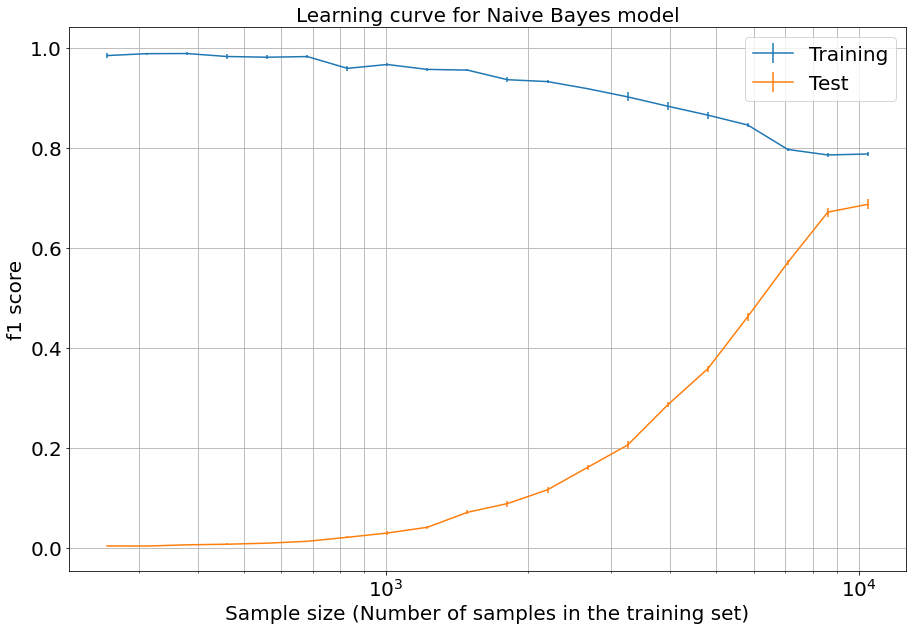

time: 159 ms (started: 2023-01-20 16:31:27 -05:00)


In [107]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.errorbar(train_size, train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1), label="Training")
plt.errorbar(train_size, test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1), label="Test")

plt.title("Learning curve for Naive Bayes model", fontsize=20)
plt.legend(fontsize=20)
plt.xscale("log")
plt.xlabel("Sample size (Number of samples in the training set)", fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("f1 score", fontsize=20)
plt.yticks(fontsize=20)

plt.grid(which='both')

### Classification report

In [114]:
lbl_names = pd.Series([item for item in df_train['category']]).value_counts(normalize=False).index.values  # Descending order
lbl_names

array(['card_payment_fee_charged', 'direct_debit_payment_not_recognised',
       'balance_not_updated_after_cheque_or_cash_deposit',
       'wrong_amount_of_cash_received', 'cash_withdrawal_charge',
       'transaction_charged_twice', 'declined_cash_withdrawal',
       'transfer_fee_charged', 'transfer_not_received_by_recipient',
       'balance_not_updated_after_bank_transfer', 'request_refund',
       'card_payment_not_recognised', 'card_payment_wrong_exchange_rate',
       'extra_charge_on_statement',
       'wrong_exchange_rate_for_cash_withdrawal', 'Refund_not_showing_up',
       'reverted_card_payment?', 'cash_withdrawal_not_recognised',
       'activate_my_card', 'pending_card_payment', 'cancel_transfer',
       'beneficiary_not_allowed', 'declined_card_payment', 'card_arrival',
       'pending_top_up', 'pending_transfer', 'top_up_reverted',
       'top_up_failed', 'pending_cash_withdrawal', 'card_linking',
       'failed_transfer', 'visa_or_mastercard', 'declined_transfer',
   

time: 7.25 ms (started: 2023-01-20 16:35:09 -05:00)


In [115]:
# Learn the intents on the training set
model_NB.fit(df_train['text'], df_train['category'])

# Predict the intent on the test set
y_pred = model_NB.predict(df_test['text'])

time: 124 ms (started: 2023-01-20 16:35:13 -05:00)


In [116]:
report = classification_report(df_test['category'], y_pred, labels=lbl_names)
print(f"Classification report for Naive Bayes classifier:\n"
      f"{report}\n")

Classification report for Naive Bayes classifier:
                                                  precision    recall  f1-score   support

                        card_payment_fee_charged       0.53      0.72      0.61        40
             direct_debit_payment_not_recognised       0.81      0.88      0.84        40
balance_not_updated_after_cheque_or_cash_deposit       0.73      0.88      0.80        40
                   wrong_amount_of_cash_received       0.62      0.90      0.73        40
                          cash_withdrawal_charge       0.78      0.70      0.74        40
                       transaction_charged_twice       0.70      1.00      0.82        40
                        declined_cash_withdrawal       0.45      0.38      0.41        40
                            transfer_fee_charged       0.62      0.45      0.52        40
              transfer_not_received_by_recipient       0.57      0.68      0.62        40
         balance_not_updated_after_bank_transfer 

### Confusion matrix

In [119]:
cm = confusion_matrix(y_true=df_test['category'], y_pred=y_pred, labels=lbl_names)

time: 10.3 ms (started: 2023-01-20 16:41:25 -05:00)


In [120]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lbl_names)

time: 506 µs (started: 2023-01-20 16:41:26 -05:00)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 [Text(0, 0, 'card_payment_fee_charged'),
  Text(1, 0, 'direct_debit_payment_not_recognised'),
  Text(2, 0, 'balance_not_updated_after_cheque_or_cash_deposit'),
  Text(3, 0, 'wrong_amount_of_cash_received'),
  Text(4, 0, 'cash_withdrawal_charge'),
  Text(5, 0, 'transaction_charged_twice'),
  Text(6, 0, 'declined_cash_withdrawal'),
  Text(7, 0, 'transfer_fee_charged'),
  Text(8, 0, 'transfer_not_received_by_recipient'),
  Text(9, 0, 'balance_not_updated_after_bank_transfer'),
  Text(10, 0, 'request_refund'),
  Text(11, 0, 'card_payment_not_recognised'),
  Text(12, 0, 'card_payment_wrong_exchange_rate'),
  Text(13, 0, 'extra_charge_on_statement

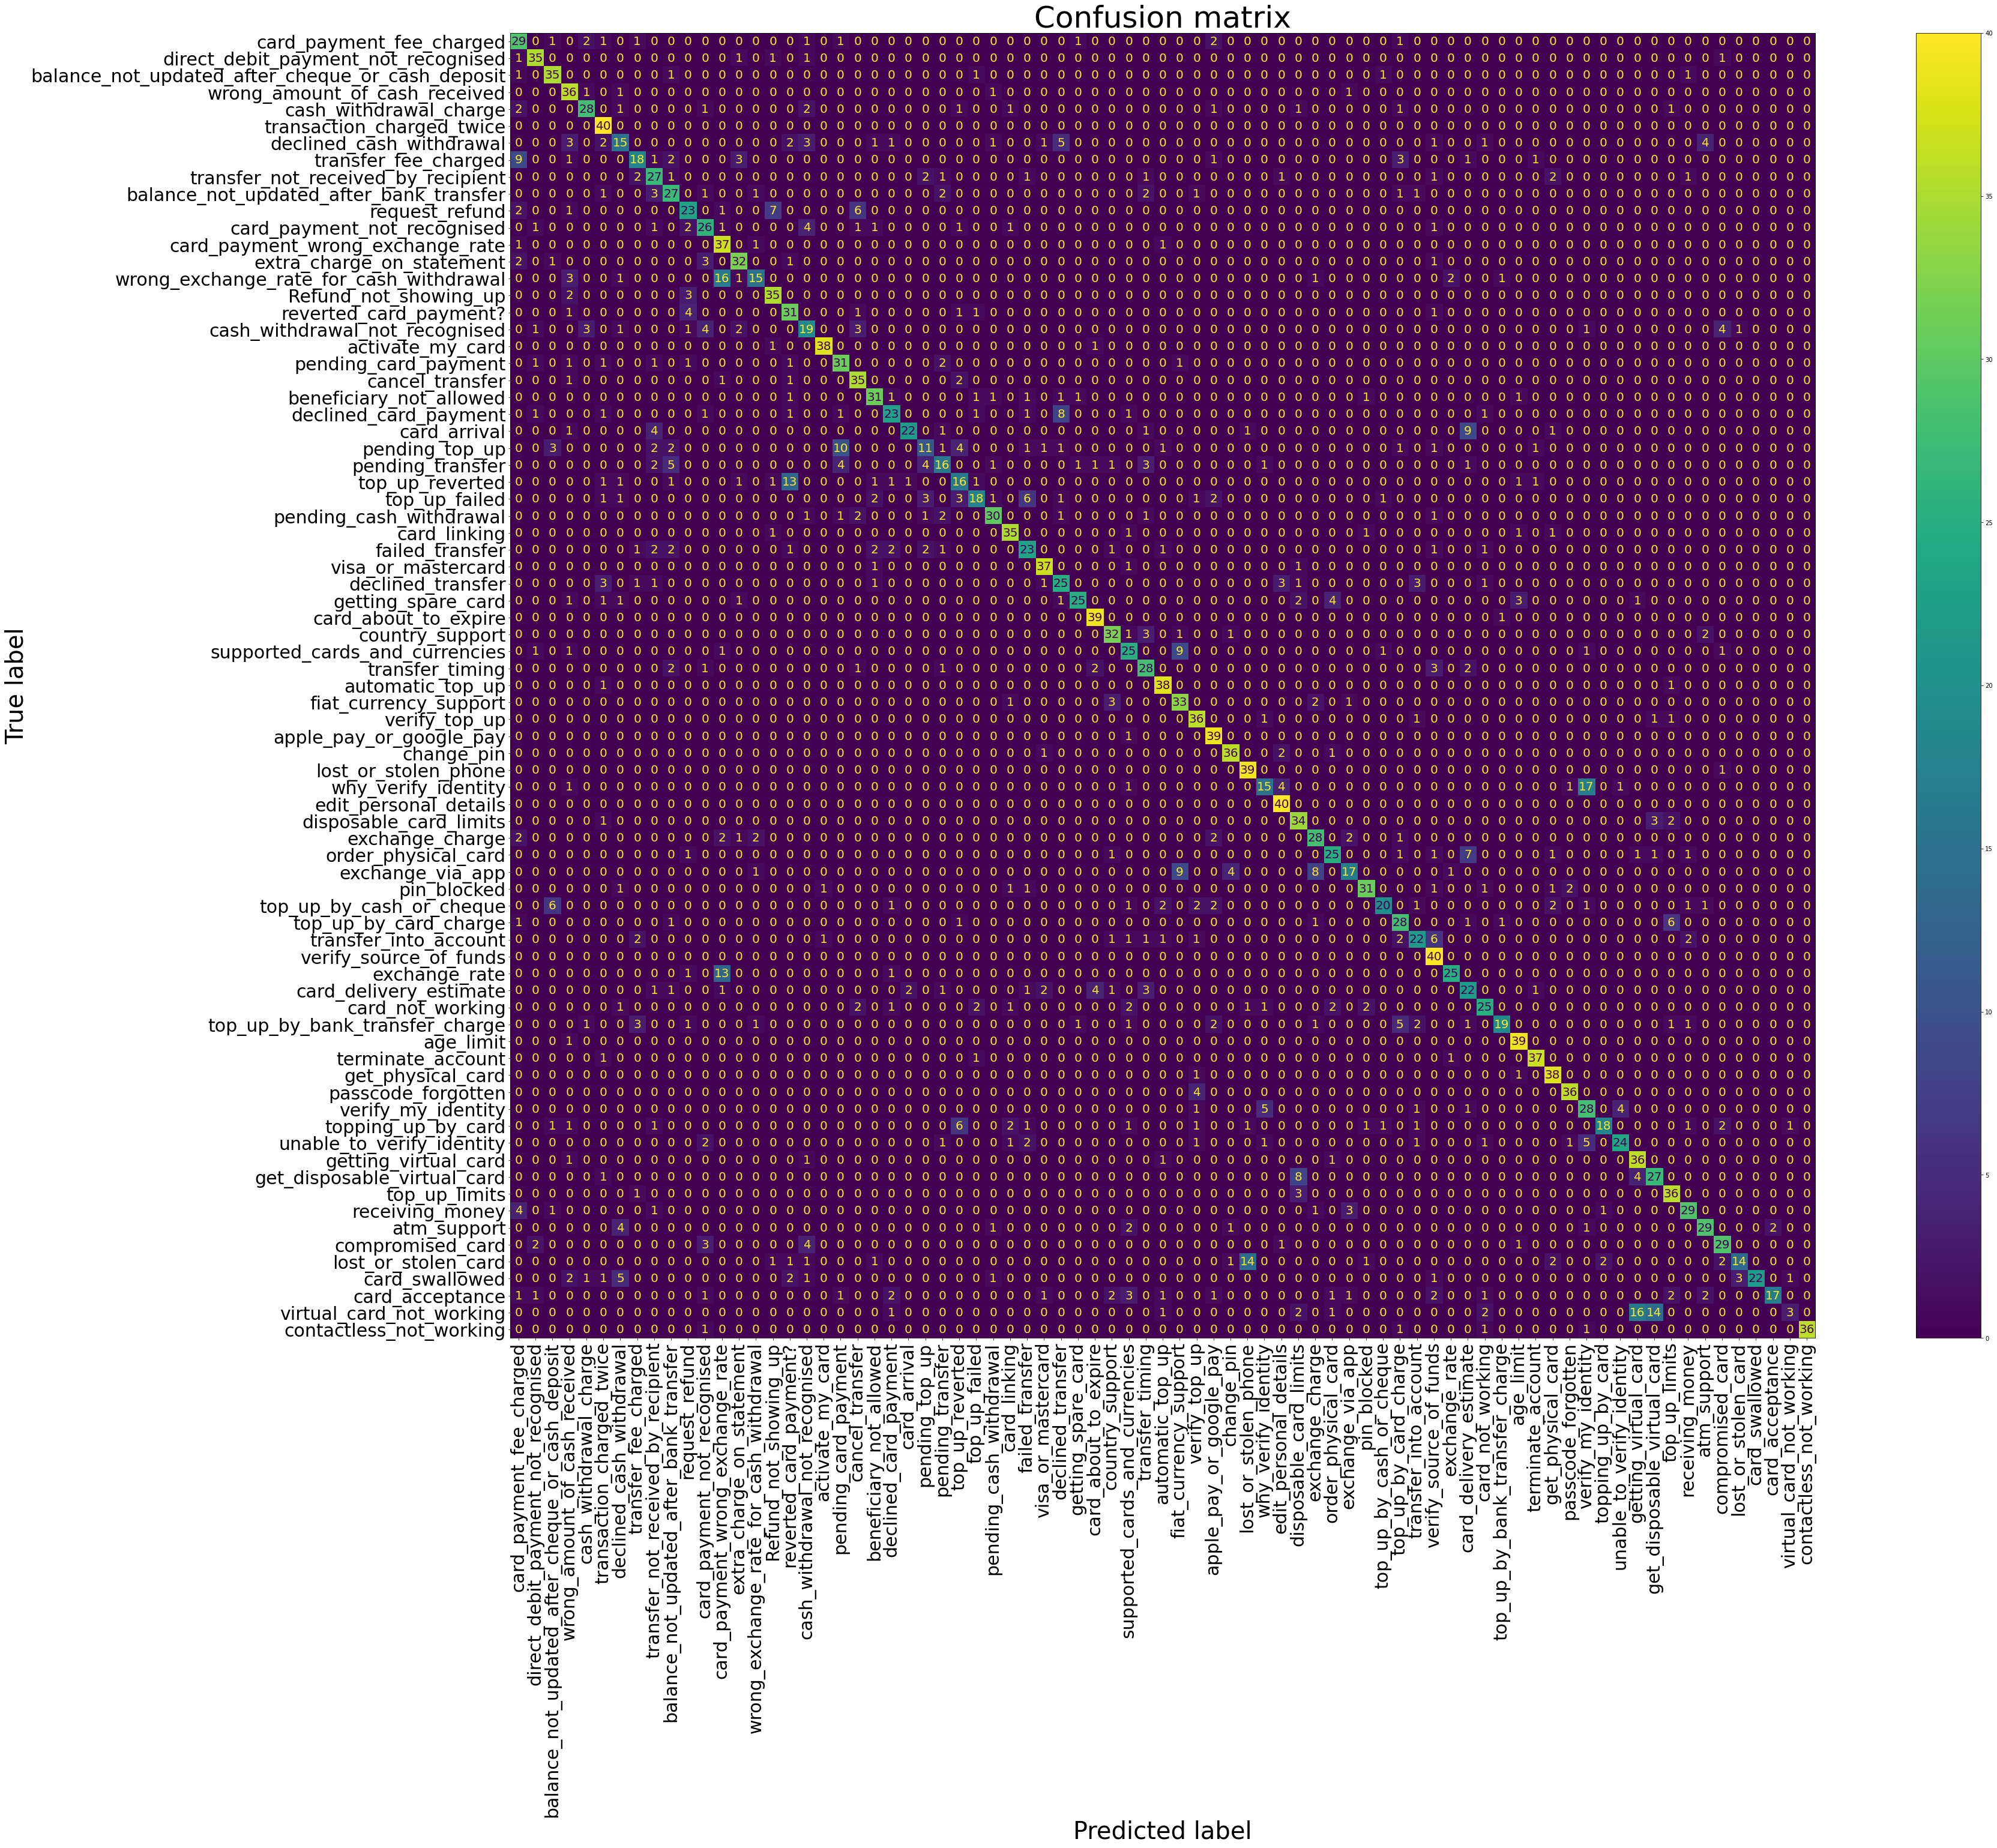

time: 5.03 s (started: 2023-01-20 16:55:48 -05:00)


In [128]:
fig, ax = plt.subplots(figsize=(60, 40))
disp.plot(ax=ax, xticks_rotation='vertical')

for labels in disp.text_.ravel():
    labels.set_fontsize(20)

ax.set_title('Confusion matrix', fontsize=50)
ax.set_ylabel('True label', fontsize=40)
ax.set_xlabel('Predicted label', fontsize=40)

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)